In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,2463,Dementia Therapy Targeting Tau.,tau microtubul associ tau protein also non mic...,Alternative Splicing; Alzheimer Disease; Demen...,0,0,0,1,0
1,2511,[Acute neuropsychiatry: a confused patient and...,anti nmda receptor enceph progress autoimmun d...,Acute Disease; Anti-N-Methyl-D-Aspartate Recep...,0,0,0,1,0
2,2227,A systematic review and meta-analysis of safet...,safinamid recent develop drug sever mechan act...,Add-on; Dopamine; Dopamine agonist; Motor; Mov...,0,0,0,1,0
3,526,Emotional intelligence and systolic blood pres...,present studi design compar emot intellig ei c...,Hear t Failure; Mean arterial pressure; Cogni...,1,0,0,0,0
4,4291,Necrotising fasciitis caused by aeromonas sobr...,necrotis fasciiti life threaten infect soft ti...,"Aeromonas; Animals; Catfishes; Diagnosis, Diff...",0,0,0,0,1
5,2986,Development of a Sleep Apnea Detection Algorit...,sleep apnea syndrom sa preval disord caus dayt...,"Algorithms; Heart Rate; Humans; Memory, Short-...",0,0,0,1,0
6,1842,Prevalence of Cryptosporidium spp. infection a...,cryptosporidium spp identifi import caus diarr...,Child; Cross-Sectional Studies; Cryptosporidio...,0,1,0,0,0
7,1142,Awareness of smoking in adolescents with infla...,inflammatori bowel diseas ibd long life diseas...,Crohn...s disease; Ulcerative colitis; environ...,0,1,0,0,0
8,3371,Immune response during influenza virus infecti...,pathogen influenza viru infect modul cytokin e...,Cytokine; Northeast India; influenza virus; pa...,0,0,0,0,1
9,5349,Identification of Ppar<i>..</i>-modulated miRN...,liver fibrosi interfer normal liver function f...,PPAR..; fibrosis; hepatocellular carcinoma; mi...,0,0,1,0,0


In [ ]:
test_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,3,Multi-organ trauma with rupture and Stanford t...,case year old car driver struck great forc tra...,blunt thoracic aortic injury (BTAI); lateral c...,1,0,0,0,0
1,4,Anticoagulant treatment in elderly patients wi...,atrial fibril af common elderli treatment cond...,anticoagulation therapy; atrial fibrillation; ...,1,0,0,0,0
2,6,Does characterising patterns of multimorbidity...,stroke transient ischaem attack tia remain lea...,integrated care; interprofessional collaborati...,1,0,0,0,0
3,8,Biological agent in prevention of ocular recur...,ocular involv beh et diseas bd character recur...,"Adalimumab; Administration, Oral; Adult; Anti-...",1,0,0,0,0
4,9,Lens induced glaucoma in a tertiary eye care c...,len induc glaucoma due hypermatur cataract imp...,Aged; Cataract; Cataract Extraction; Eye Pain;...,1,0,0,0,0
5,11,Ventricular bigeminy in enteric fever.,salmonella infect caus wide rang intestin extr...,Adult; Anti-Bacterial Agents; Electrocardiogra...,1,0,0,0,0
6,14,TORSADES DE POINTES IN ELDERLY PATIENT WITH PA...,one drug wide use treatment atrial fibril amio...,Amiodarone; Atrial fibrillation; Bradycardia; ...,1,0,0,0,0
7,15,Transcatheter InterAtrial Shunt Device for the...,random sham control trial patient heart failur...,Cardiac Catheterization; Double-Blind Method; ...,1,0,0,0,0
8,22,[Endothelial dysfunction in patients with cont...,conduct compar analysi level asymmetr dimethyl...,arterial hypertension; asymmetric dimethylargi...,1,0,0,0,0
9,23,[Autoantibodies to M2-cholinoreceptors as a po...,aim assess autoantibodi m2 cholinoceptor m2 cr...,M2 cholinoceptors; arterial hypertension; atri...,1,0,0,0,0


In [ ]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

vocab = Counter()

def text_to_wordlist(text, lower=False):
  text = tokenizer.tokenize(text)
  #text = [w for w in text if len(w) != 1]
  vocab.update(text)
  return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)

    return comments

list_sentences_train = list(train_df["abstract"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["abstract"].fillna("NAN_WORD").values)

#Todas las keywords
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

Processing text dataset


100%|██████████| 5417/5417 [00:00<00:00, 12077.64it/s]


In [ ]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 30420 unique tokens


In [ ]:
!pip install glove_python

     |████████████████████████████████| 266kB 10.7MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=695672 sha256=41928f37d80c6555a4bba262897df8ef4b24282a157e88b5b322f38bb410464f
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [ ]:
import glove
from glove import Glove, Corpus

corpus = Corpus()
corpus.fit(comments, window=5)

model = Glove(no_components=100, learning_rate=0.05)
model.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)

In [ ]:
word_vectors = model.word_vectors
print("Number of word vectors: {}".format(len(word_vectors)))

Number of word vectors: 30420


In [ ]:
model.add_dictionary(corpus.dictionary)
model.most_similar('fail', 10)

[('adequ', 0.7014336848113285),
 ('conserv', 0.6624990144899058),
 ('choic', 0.660459137073905),
 ('suitabl', 0.6557183859547417),
 ('necessari', 0.6499478005533439),
 ('start', 0.630348003542429),
 ('symptomat', 0.6209913482990665),
 ('option', 0.6165436645852386),
 ('begin', 0.6091002612966987)]

In [ ]:
word_vectors.shape

(30420, 150)

In [ ]:
#Definimos el tamaño de los vectores. Al estar trabajando con keywords podemos escoger un tamaño que no sea muy grane
MAX_NB_WORDS = len(word_vectors)
MAX_SEQUENCE_LENGTH = 30

In [ ]:
from keras.preprocessing.sequence import pad_sequences
#Dictionary with the words index asigned from our dictionary vocab 
#Diccionario con todas las palabras asignadas un i + 1. 
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TRAIN)
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TEST)
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# Mediante la funcion pad_sequences recortamos los vectores de keywords a una longitud determinada, en este caso 20. 
#Ajuste del tamaño para TRAIN
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

list_classes = ["Cardio", "Diges", "Resp", "Nerv", "Infe"]
y = train_df[list_classes].values
print('Shape de los tensores training (data):', data.shape)
print('Shape de los tensores label del training (y):', y.shape)

#Ajuste del tamaño para TEST
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post",
                          truncating="post")
print('Shape de los tensores del test (test_data):', test_data.shape)

Shape de los tensores training (data): (3629, 30)
Shape de los tensores label del training (y): (3629, 5)
Shape de los tensores del test (test_data): (1788, 30)


In [ ]:
# Comprobamos la correspondencia entre ambos vectores, es decir, que tengan el mismo valor (mismo número) que en el diccionario generado (word_index)
#COMPROBACION TEST
list_sentences_test[9]

'M2 cholinoceptors; arterial hypertension; atrial fibrillation; autoantibodies; Atrial Fibrillation; Autoantibodies; Electrocardiography; Electrocardiography, Ambulatory; Humans; Hypertension'

In [ ]:
#longitud original
print(test_sequences[0])

[11817, 2332, 1293, 309, 11818, 1741, 11819, 11820, 2234, 2421, 2030, 2332, 3791, 1293, 2841, 11821, 1527, 1293, 11822, 216, 1575, 1821, 325, 3486, 325, 3790, 1038, 313, 227, 325, 313, 1, 3, 7, 2, 135, 1146, 313, 134, 24, 22, 207, 110, 126]


In [ ]:
word_index['thoracic']

2332

In [ ]:
#longitud despues del padding
test_data[0]

array([11817,  2332,  1293,   309, 11818,  1741, 11819, 11820,  2234,
        2421,  2030,  2332,  3791,  1293,  2841, 11821,  1527,  1293,
       11822,   216,  1575,  1821,   325,  3486,   325,  3790,  1038,
         313,   227,   325], dtype=int32)

In [ ]:
#COMPROBACION TRAIN
list_sentences_train[0]

'Alternative Splicing; Alzheimer Disease; Dementia; Humans; Tauopathies; tau Proteins'

In [ ]:
#longitud original
sequences[0]

[3581, 3582, 147, 9, 350, 1, 1022, 580, 40]

In [ ]:
word_index['Alternative']

In [ ]:
#longitud despues del padding
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3581,
       3582,  147,    9,  350,    1, 1022,  580,   40], dtype=int32)

In [ ]:
#ETIQUETAS
y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [ ]:
# Preparacion de la embedding matrix

WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

#hacemos la embedding matrix con los vectores del word2vec
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import keras

#añadimos un control de forma que si se dan dos epocas sin mejorar accuracy se corta el entrenamiento y se escoge el mejor modelo. 
callbacks_list = [keras.callbacks.EarlyStopping(
                  monitor='accuracy',
                  patience=3,),
                  keras.callbacks.ModelCheckpoint(
                  filepath='my_model.h5',
                  monitor='val_loss',
                  save_best_only=True,)]

wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(128, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
preds = Dense(5, activation='softmax')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='mae',
              optimizer='rmsprop',
              metrics=['accuracy']) 

In [ ]:
model.summary() 

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 30, 150)           537000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 30, 150)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256)               285696    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 823,981
Trainable params: 286,981
Non-trainable params: 537,000
_________________________________________

In [ ]:
word2vec_k_m= model.fit([data], y, validation_split=0.1,
                 epochs=30, batch_size=150, shuffle=True)

#val --> resultado con los test
# loss y val_loss deben tener casi el mismo valor y el mas bajo posible del orden de ~0,01
# si loss < val_loss --> overfitting
# si loss > val_loss --> underfitting 

Epoch 1/30
22/22 [==============================] - 10s 301ms/step - loss: 0.2974 - accuracy: 0.2897 - val_loss: 0.3106 - val_accuracy: 0.4105
Epoch 2/30
22/22 [==============================] - 5s 247ms/step - loss: 0.2183 - accuracy: 0.4805 - val_loss: 0.3053 - val_accuracy: 0.4573
Epoch 3/30
22/22 [==============================] - 5s 244ms/step - loss: 0.1949 - accuracy: 0.5333 - val_loss: 0.2981 - val_accuracy: 0.5069
Epoch 4/30
22/22 [==============================] - 5s 241ms/step - loss: 0.1847 - accuracy: 0.5678 - val_loss: 0.2946 - val_accuracy: 0.4876
Epoch 5/30
22/22 [==============================] - 5s 243ms/step - loss: 0.1764 - accuracy: 0.5801 - val_loss: 0.2895 - val_accuracy: 0.4490
Epoch 6/30
22/22 [==============================] - 5s 241ms/step - loss: 0.1738 - accuracy: 0.5906 - val_loss: 0.2853 - val_accuracy: 0.5014
Epoch 7/30
22/22 [==============================] - 5s 243ms/step - loss: 0.1643 - accuracy: 0.6062 - val_loss: 0.2789 - val_accuracy: 0.4959
Epoch

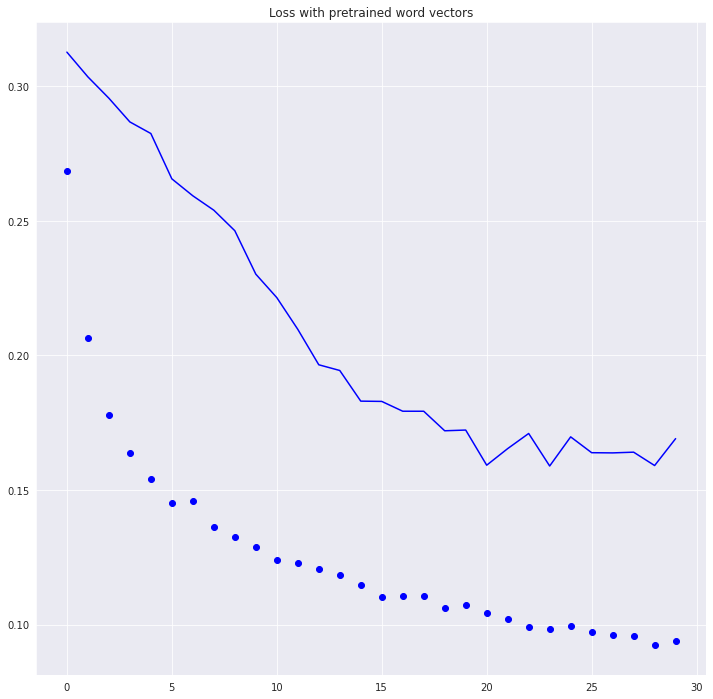

In [ ]:
history = pd.DataFrame(word2vec_k_m.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"], 'bo'); #puntos
plt.plot(history["val_loss"], 'b'); #linea
plt.title("Loss with pretrained word vectors");
plt.show();

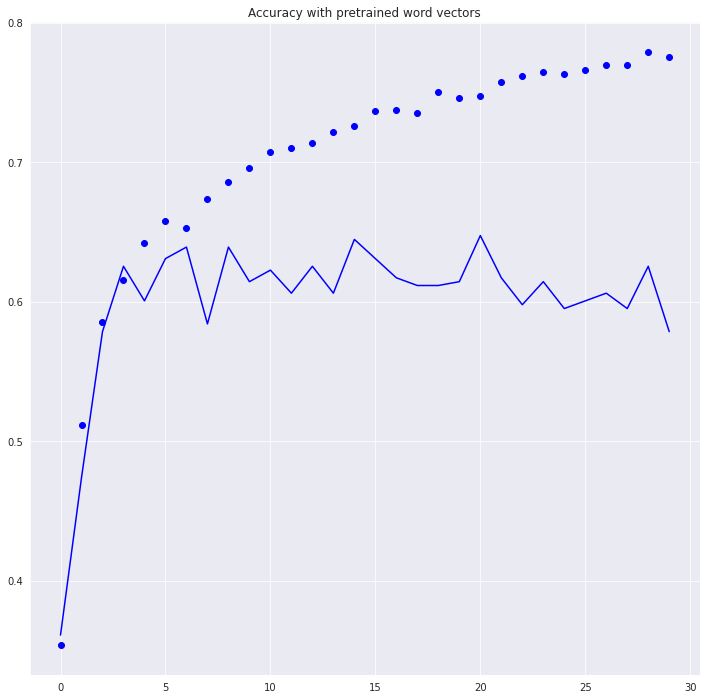

In [ ]:
history = pd.DataFrame(word2vec_k_m.history)
plt.figure(figsize=(12,12));
plt.plot(history["accuracy"],'bo');
plt.plot(history["val_accuracy"], 'b');
plt.title("Accuracy with pretrained word vectors");
plt.show();